# Building a Class-Conditional Dataset

In this chapter, we'll learn how to build few-shot learning episodes from a musical instrument recognition dataset. 

In particular, we will be using the [TinySOL](https://zenodo.org/record/3685367) dataset, which is a collection of recordings of 14 musical instruments playing a single musical note. We will use the [mirdata](https://github.com/mir-dataset-loaders/mirdata) library to load the TinySOL dataset. 

We will then implement an Episodic Sampler, which will be used to sample support and query sets for each episode, from the TinySOL dataset.

Requirements (hidden)

In [1]:
%%capture
!pip install mirdata
!pip install numpy
!pip install --no-cache-dir --upgrade music-fsl

In [2]:
from typing import Tuple
from collections import defaultdict

import numpy as np
import mirdata

import music_fsl.util as util
from music_fsl.util import widget

## Setting up TinySOL with `mirdata`

`mirdata` makes it easy to download MIR datasets. The following snippet takes care of downloading the TinySOL dataset.

In [3]:
dataset = mirdata.initialize('tinysol')
dataset.download()

INFO: Downloading ['audio', 'annotations'] to /home/hugo/mir_datasets/tinysol
INFO: [audio] downloading TinySOL.tar.gz
INFO: /home/hugo/mir_datasets/tinysol/audio/TinySOL.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotations] downloading TinySOL_metadata.csv
INFO: /home/hugo/mir_datasets/tinysol/annotation/TinySOL_metadata.csv already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.


Let's look at a sample from our dataset.

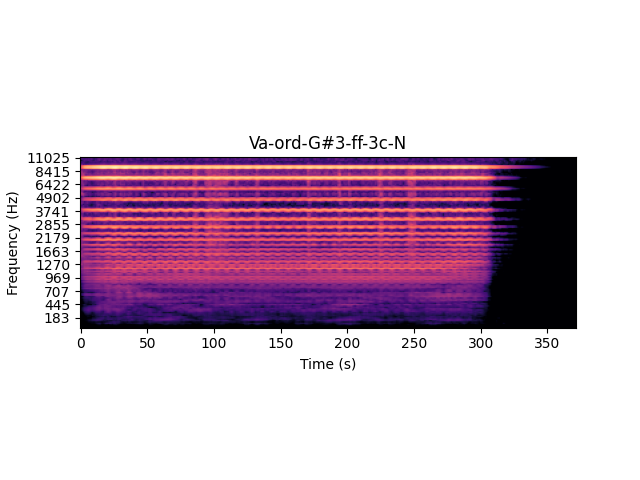

(None, None)

<Figure size 640x480 with 0 Axes>

In [4]:
example_track = dataset.choice_track()

widget(example_track.audio_path)

## Making a Class Conditional Dataset

In order to be able to sample few-shot learning episodes, we need to be able to arbitrarily sample items from a given class. 

We'll start by making an abstract class that will define the interface for a class conditional dataset. This class, called `ClassConditionalDataset`, will define the following three methods:

1. `__getitem__(index)`: Just like any other PyTorch dataset, this method should be used to grab an item from the dataset by providing the index of the item you want to retrieve. To properly collate the data later, the returned item must be a dictionary. 

2. `classlist`: This property returns a list of class labels available in the dataset. This property enables users of the dataset to easily access a list of all the classes in the dataset.

3. `class_to_indices`: This property returns a dictionary where the keys are class labels and the values are lists of indices in the dataset that belong to that class. This property enables users of the dataset to easily access examples that belong to specific classes.


In [5]:
import torch
from typing import List, Dict, Any

class ClassConditionalDataset(torch.utils.data.Dataset):

    def __getitem__(self, index: int) -> Dict[Any, Any]:
        """
        Grab an item from the dataset. The item returned must be a dictionary. 
        """
        raise NotImplementedError
    
    @property
    def classlist(self) -> List[str]:
        """
        The classlist property returns a list of class labels available in the dataset.
        This property enables users of the dataset to easily access a list of all the classes in the dataset.

        Returns:
            List[str]: A list of class labels available in the dataset. 
        """
        raise NotImplementedError

    @property
    def class_to_indices(self) -> Dict[str, List[int]]:
        """
        Returns a dictionary where the keys are class labels and the values are 
        lists of indices in the dataset that belong to that class. 
        This property enables users of the dataset to easily access 
        examples that belong to specific classes. 

        Implement me!

        Returns:
            Dict[str, List[int]]: A dictionary mapping class labels to lists of dataset indices. 
        """
        raise NotImplementedError

The abstract class will be useful for any dataset that we want to use for episodic training. 
Now, let's implement a concrete class for the TinySOL dataset. 

Let's start with the `__init__` method. We'll need to pass in a list of instruments to use as a subset so we can have a training and test set with different instruments.

```python
class TinySOL(ClassConditionalDataset):
    """
    Initialize a `TinySOL` dataset instance.

    Args:
        instruments (List[str]): A list of instruments to include in the dataset.
        duration (float): The duration of each audio clip in the dataset (in seconds).
        sample_rate (int): The sample rate of the audio clips in the dataset (in Hz).
    """

    INSTRUMENTS = [
        'Bassoon', 'Viola', 'Trumpet in C', 'Bass Tuba',
        'Alto Saxophone', 'French Horn', 'Violin', 
        'Flute', 'Contrabass', 'Trombone', 'Cello', 
        'Clarinet in Bb', 'Oboe', 'Accordion'
    ]

    def __init__(self, 
            instruments: List[str] = None,
            duration: float = 1.0, 
            sample_rate: int = 16000,
        ):
        # use all instruments if none are specified
        if instruments is None:
            instruments = self.INSTRUMENTS

        self.instruments = instruments
        self.duration = duration
        self.sample_rate = sample_rate

        # initialize the tinysol dataset and download if necessary
        self.dataset = mirdata.initialize('tinysol')
        self.dataset.download()

        # make sure the instruments passed in are valid
        for instrument in instruments:
            assert instrument in self.INSTRUMENTS, f"{instrument} is not a valid instrument"

        # load all tracks for this instrument
        self.tracks = []
        for track in self.dataset.load_tracks().values():
            if track.instrument_full in self.instruments:
                self.tracks.append(track)
```

Awesome! Since the user already passed in the list of instruments that they want to use, we can just return `self.instruments` in the `classlist` property.

```python
    @property
    def classlist(self) -> List[str]:
        return self.instruments
```

Next in the requirements for the `ClassConditionalDataset` is the `class_to_indices` mapping. This is a dictionary where the keys are class labels and the values are lists of indices in the dataset that belong to that class.

In order to only have to iterate through all tracks once, we will cache the property in an internal variable, `self._class_to_indices`. 

```python
    @property
    def class_to_indices(self) -> Dict[str, List[int]]:
        # cache it in self._class_to_indices 
        # so we don't have to recompute it every time
        if not hasattr(self, "_class_to_indices"):
            self._class_to_indices = defaultdict(list)
            for i, track in enumerate(self.tracks):
                self._class_to_indices[track.instrument_full].append(i)

        return self._class_to_indices

```

We can implement the `__getitem__` and `__len__` methods. The `__getitem__` method should be just like any other PyTorch dataset, where we return the item at the given index. The `__len__` method should return the length of the dataset.

In this case, the item is a dictionary containing an audio excerpt as a numpy array and the instrument label as a string. We're using a function called `load_excerpt` to load an excerpt of audio of a given sample rate and duration, but the implementation details of said function are out of this tutorial's scope. 

```python

    def __getitem__(self, index) -> Dict:
        # load the track for this index
        track = self.tracks[index]

        # load the excerpt
        data = util.load_excerpt(track.audio_path, self.duration, self.sample_rate)
        data["label"] = track.instrument_full

        return data

    def __len__(self) -> int:
        return len(self.tracks)
```

Below is the full implementation of the dataset, including the `load_excerpt` function.

In [6]:

class TinySOL(ClassConditionalDataset):
    """
    Initialize a `TinySOL` dataset instance.

    Args:
        instruments (List[str]): A list of instruments to include in the dataset.
        duration (float): The duration of each audio clip in the dataset (in seconds).
        sample_rate (int): The sample rate of the audio clips in the dataset (in Hz).
    """

    INSTRUMENTS = [
        'Bassoon', 'Viola', 'Trumpet in C', 'Bass Tuba',
        'Alto Saxophone', 'French Horn', 'Violin', 
        'Flute', 'Contrabass', 'Trombone', 'Cello', 
        'Clarinet in Bb', 'Oboe', 'Accordion'
    ]

    def __init__(self, 
            instruments: List[str] = None,
            duration: float = 1.0, 
            sample_rate: int = 16000,
        ):
        if instruments is None:
            instruments = self.INSTRUMENTS

        self.instruments = instruments
        self.duration = duration
        self.sample_rate = sample_rate

        # initialize the tinysol dataset and download if necessary
        self.dataset = mirdata.initialize('tinysol')
        self.dataset.download()

        # make sure the instruments passed in are valid
        for instrument in instruments:
            assert instrument in self.INSTRUMENTS, f"{instrument} is not a valid instrument"

        # load all tracks for this instrument
        self.tracks = []
        for track in self.dataset.load_tracks().values():
            if track.instrument_full in self.instruments:
                self.tracks.append(track)


    @property
    def classlist(self) -> List[str]:
        return self.instruments

    @property
    def class_to_indices(self) -> Dict[str, List[int]]:
        # cache it in self._class_to_indices 
        # so we don't have to recompute it every time
        if not hasattr(self, "_class_to_indices"):
            self._class_to_indices = defaultdict(list)
            for i, track in enumerate(self.tracks):
                self._class_to_indices[track.instrument_full].append(i)

        return self._class_to_indices

    def __getitem__(self, index) -> Dict:
        # load the track for this index
        track = self.tracks[index]

        # load the excerpt
        data = util.load_excerpt(track.audio_path, self.duration, self.sample_rate)
        data["label"] = track.instrument_full

        return data

    def __len__(self) -> int:
        return len(self.tracks)

#### Trying it out

Our class conditional dataset is ready to go! Let's try it out. 

In [7]:
dataset = TinySOL()

print(f"The dataset has {len(dataset)} examples.")
print(f"The dataset has {len(dataset.classlist)} classes.\n")

# print the number of examples for each class
for instrument, indices in dataset.class_to_indices.items():
    print(f"{instrument} has {len(indices)} examples")

INFO: Downloading ['audio', 'annotations'] to /home/hugo/mir_datasets/tinysol
INFO: [audio] downloading TinySOL.tar.gz
INFO: /home/hugo/mir_datasets/tinysol/audio/TinySOL.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotations] downloading TinySOL_metadata.csv
INFO: /home/hugo/mir_datasets/tinysol/annotation/TinySOL_metadata.csv already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.


The dataset has 2913 examples.
The dataset has 14 classes.

Bass Tuba has 108 examples
French Horn has 134 examples
Trombone has 117 examples
Trumpet in C has 96 examples
Accordion has 689 examples
Cello has 291 examples
Contrabass has 309 examples
Viola has 309 examples
Violin has 284 examples
Alto Saxophone has 99 examples
Bassoon has 126 examples
Clarinet in Bb has 126 examples
Flute has 118 examples
Oboe has 107 examples


Super! Here's a recap of what we did this chapter: 

- We downloaded the `TinySOL` dataset using `mirdata`.
- We implemented an abstract class for creating class-conditional datasets, which we called `ClassConditionalDataset`. The `ClassConditionalDataset` behaves similarly to a PyTorch dataset, but it also has a `classlist` property that returns a list of all the classes in the dataset, and a `class_to_indices` property that returns a dictionary where the keys are class labels and the values are lists of indices in the dataset that belong to that class. This lets a user easily access examples that belong to specific classes, which will be useful for building few-shot learning episodes. 

- We implemented a class-conditional version of the `TinySOL` dataset, which we will use for training our few-shot learning model.

In the next chapter, we'll implement a sampler for our class-conditional dataset, which will enable us to sample episodes for training and evaluating our few-shot learning model.